In [1]:
import torch
import torchvision

In [2]:
print(f'torch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [3]:
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except ImportError:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the modules, download them from your GitHub if they don't exist
try:
    import data_setup
    import engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except ImportError:
    print("[INFO] Couldn't find Helper_function-Pytorch scripts... downloading them from GitHub.")
    # Clone the GitHub repository
    !git clone https://github.com/AnandhuSalimkumar/Helper_function-Pytorch.git
    !mv Helper_function-Pytorch/* .  # Move all scripts to the working directory
    !rm -rf Helper_function-Pytorch  # Clean up the cloned repo



[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find Helper_function-Pytorch scripts... downloading them from GitHub.
Cloning into 'Helper_function-Pytorch'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16 (delta 2), reused 11 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 12.58 KiB | 2.52 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [4]:
# Reattempt imports after downloading
import data_setup
import engine
from helper_functions import download_data, set_seeds, plot_loss_curves

In [5]:
# setup device agnostic code

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
image_path = download_data(source="https://github.com/AnandhuSalimkumar/data/raw/refs/heads/main/pizza_steak_sushi.zip",
                           destination="pizza_stake_sushi")
image_path

[INFO] Did not find data/pizza_stake_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/AnandhuSalimkumar/data/raw/refs/heads/main/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_stake_sushi')

In [7]:
# setup the training and testing directory
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
train_dir,test_dir

(PosixPath('data/pizza_stake_sushi/train'),
 PosixPath('data/pizza_stake_sushi/test'))

**Create Dataset and Data Loaders**

In [9]:
from re import I
import data_setup

# create image size

IMG_SIZE = 224 # we get this from the table 3 of the VIT paper

# Create a transform pipline
manual_transforms = transforms.Compose([transforms.Resize((IMG_SIZE,IMG_SIZE)),
                                        transforms.ToTensor()])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [10]:
# create a batch size of 32. Since the VIT paper uses 4096 but this may be too big for our small gpu
BATCH_SIZE = 32

# Create Dataloaders
train_dataloader,test_dataloader,class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                             test_dir=test_dir,
                                                                             transform=manual_transforms,
                                                                             batch_size = BATCH_SIZE)

len(train_dataloader),len(test_dataloader),class_names

(8, 3, ['pizza', 'steak', 'sushi'])

 **Let's visualize the image**



In [11]:
# Get a batch of images and labels
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and label shape
print(f"Image shape: {image.shape}, Label: {label}")


Image shape: torch.Size([3, 224, 224]), Label: 2


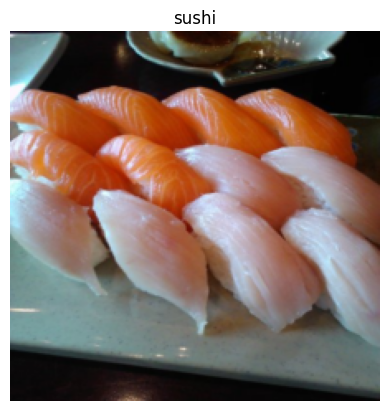

In [12]:
import matplotlib.pyplot as plt

# Plot the image
plt.imshow(image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C) for plotting
plt.title(class_names[label])       # Use the class name as the title
plt.axis('off')                     # Turn off axes for cleaner visualization
plt.show()                          # Display the plot


In [13]:
# Equation 1 : spliting the data into patches and creating the class , position and patch embedding

In [14]:
# create example values
height = 224
width = 224
color_channels = 3
patch_size = 16 # vit paper

# calculate the number of patches
number_of_patches = int((height*width)/patch_size**2)
number_of_patches


196

In [15]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

#output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)
print(f'input shape of(single 2d image): {embedding_layer_input_shape}')
print(f'output shape of (single 1d squence of patches): {embedding_layer_output_shape}')

input shape of(single 2d image): (224, 224, 3)
output shape of (single 1d squence of patches): (196, 768)


### Turn a single image into patches

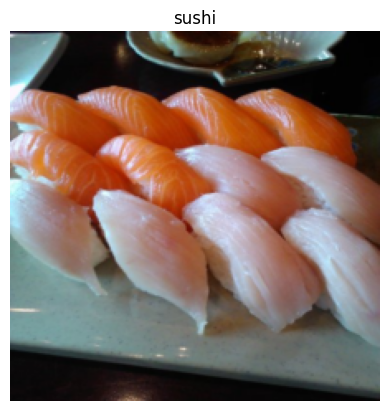

In [16]:
# let's view a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [17]:
image.shape

torch.Size([3, 224, 224])

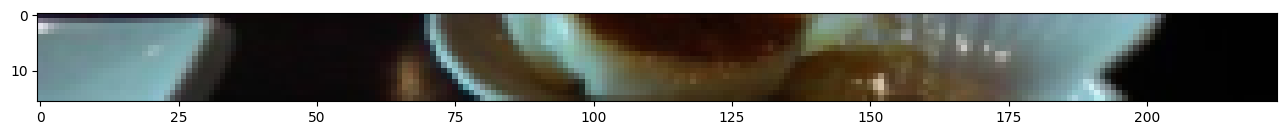

In [18]:
# Get the top raw of the image
image_permuted = image.permute(1,2,0) # convert image to color channels last (H,W,C)

# index to plot the top raw of pixels
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size,:,:])


number of patches per row: 14.0
patch size: 16 pixels x 16 pixels


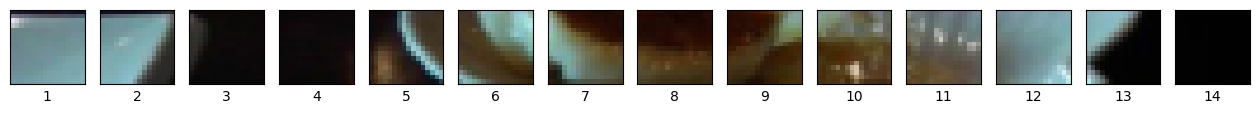

In [19]:

# setup code to plot top raw as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size ==0, "Image size must be divisibe by patch size"
print(f'number of patches per row: {num_patches}\npatch size: {patch_size} pixels x {patch_size} pixels')


# create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size//patch_size, # one column for each patch
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size,patch_size))
# Iterate through the number of patches through the top row
for i, patch in enumerate(range(0,img_size,patch_size)):
  axs[i].imshow(image_permuted[:patch_size,patch:patch+patch_size,:]);
  axs[i].set_xlabel(i+1) # set the patch label
  axs[i].set_xticks([])
  axs[i].set_yticks([])

import matplotlib.pyplot as plt

# Setup image size and patch size
img_size = 224
patch_size = 16
num_patches = img_size // patch_size  # Ensure integer division
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f'Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels')

# Permute image for plotting
image_permuted = image.permute(1, 2, 0)  # Convert (C, H, W) to (H, W, C)

# Create a series of subplots
fig, axs = plt.subplots(
    nrows=1,
    ncols=num_patches,  # One column for each patch
    figsize=(20, 5),    # Adjust figure size
    sharex=True,
    sharey=True,
)

# Iterate through the number of patches along the top row
for i, patch_start in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch_start:patch_start + patch_size, :])  # Extract top-row patch
    axs[i].set_xlabel(f"Patch {i+1}")  # Set the patch label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

# Adjust spacing and display
plt.tight_layout()
plt.show()


Number of patches per row: 14.0
Number of patches per columns: 14.0
Total patches : 196.0
patch size: 16 pixels x 16 pixels


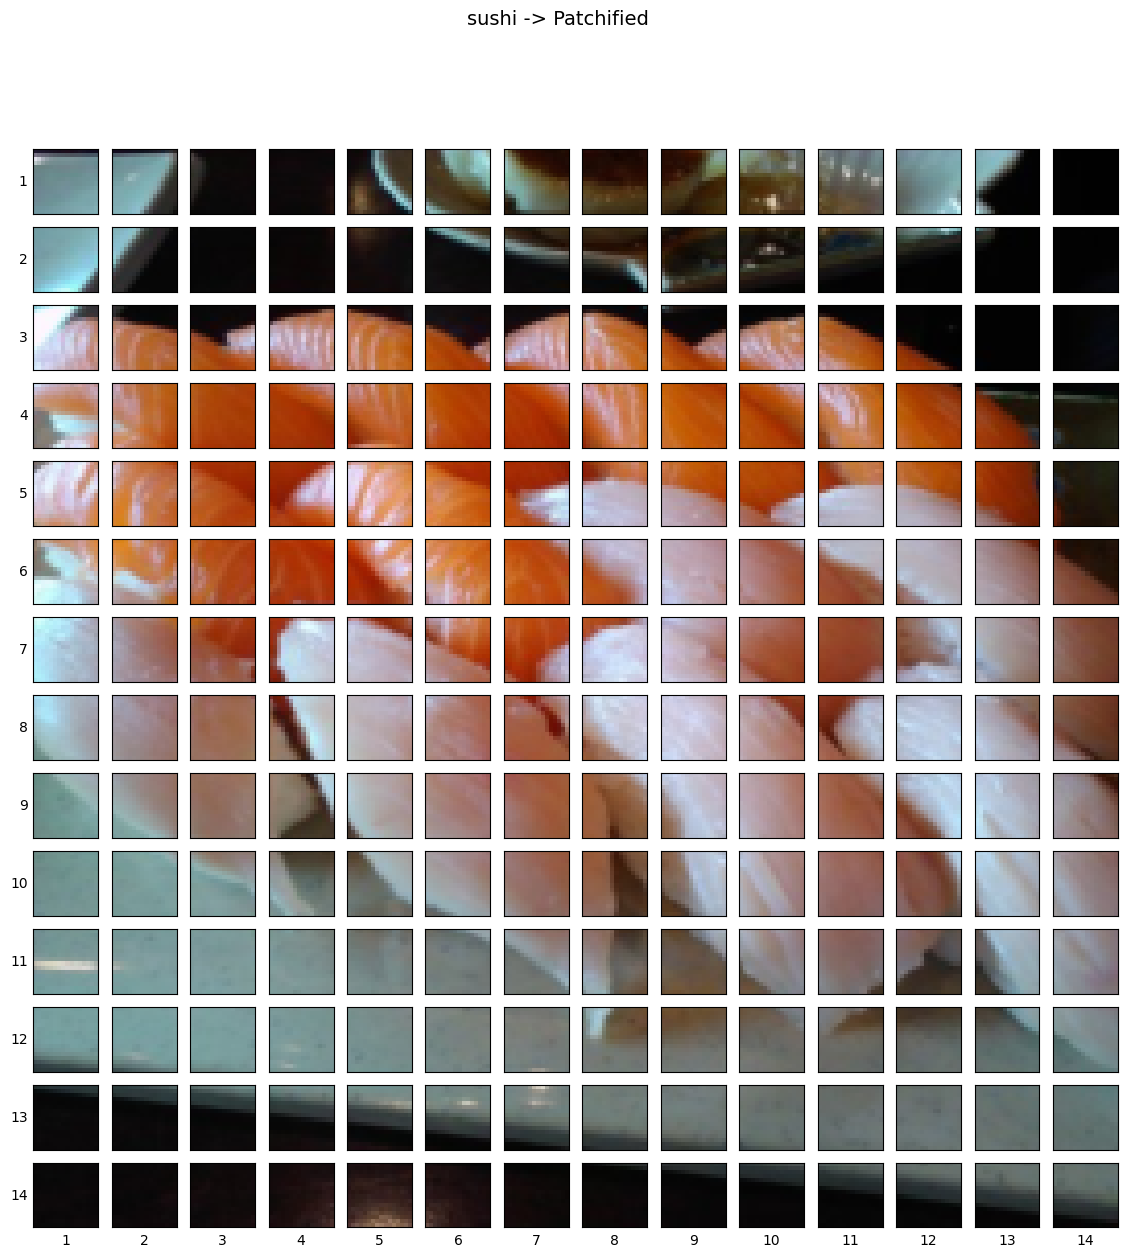

In [20]:
# setup code to plot the whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size ==0, "img_size must be divisible by patch_size"
print(f'Number of patches per row: {num_patches}\
\nNumber of patches per columns: {num_patches}\
\nTotal patches : {num_patches*num_patches}\
\npatch size: {patch_size} pixels x {patch_size} pixels')


# Create a series of subplots
fig,axs = plt.subplots(nrows=img_size//patch_size,
                       ncols=img_size//patch_size,
                       figsize=(num_patches,num_patches),
                       sharex=True,
                       sharey=True)

# Loop through height and width of the image
for i , patch_height in enumerate(range(0,img_size,patch_size)):
  for j , patch_width in enumerate(range(0,img_size,patch_size)):
    # plot the permuted image on the different axes
    axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                   patch_width:patch_width+patch_size, # iterate through width
                                   :]) # get all color

    # setup label information for each subplots
    axs[i,j].set_ylabel(i+1,
                        rotation='horizontal',
                        horizontalalignment='right',
                        verticalalignment='center')
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

# setup a title for the plot
fig.suptitle(f'{class_names[label]} -> Patchified',fontsize=14)
plt.show()

Number of patches per row: 14
Number of patches per column: 14
Total patches: 196
Patch size: 16 pixels x 16 pixels


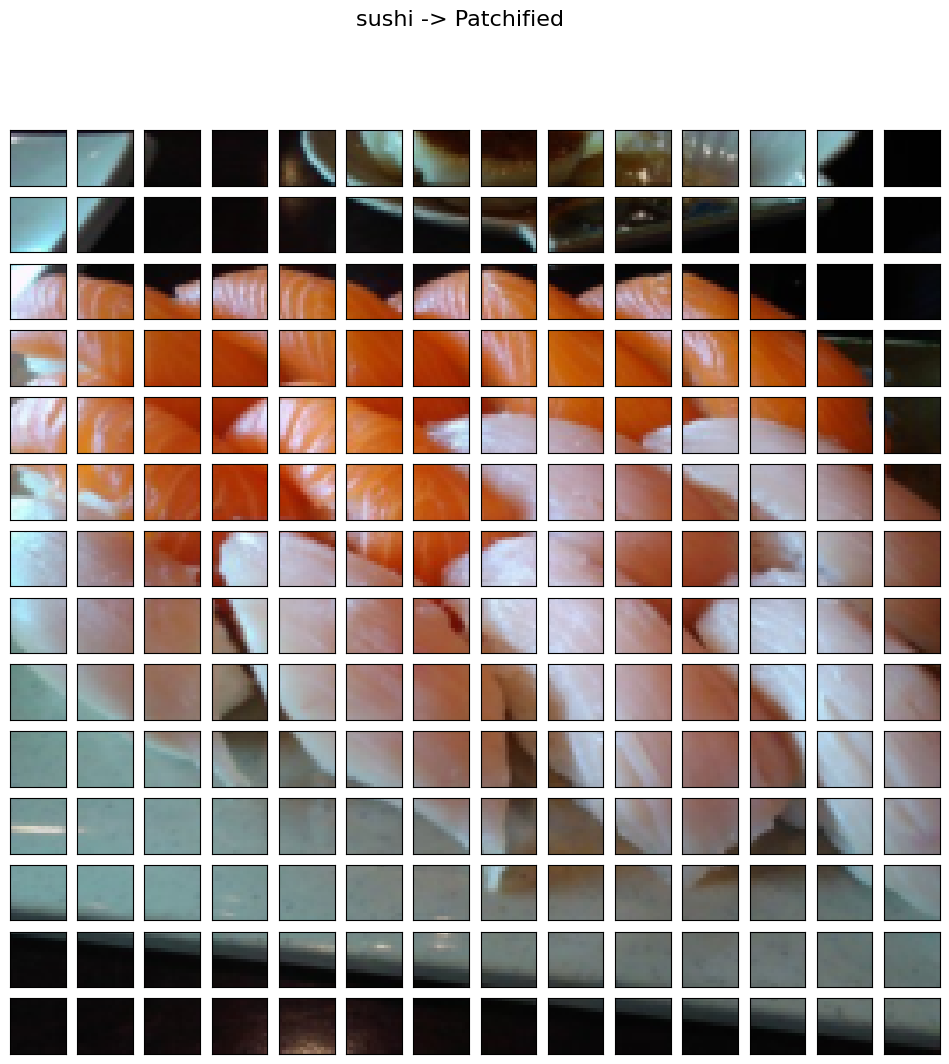

In [21]:
# Setup code to divide and display the image as patches
img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "img_size must be divisible by patch_size"

print(f'Number of patches per row: {num_patches}\n'
      f'Number of patches per column: {num_patches}\n'
      f'Total patches: {num_patches * num_patches}\n'
      f'Patch size: {patch_size} pixels x {patch_size} pixels')

# Permute image for proper viewing
image_permuted = image.permute(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)

# Create subplots
fig, axs = plt.subplots(
    nrows=num_patches,
    ncols=num_patches,
    figsize=(12, 12),  # Adjust figure size for visibility
    sharex=True,
    sharey=True
)

# Loop through height and width of the image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the patches on respective axes
        axs[i, j].imshow(
            image_permuted[patch_height:patch_height + patch_size,  # Iterate through height
                           patch_width:patch_width + patch_size,    # Iterate through width
                           :]                                       # Get all color channels
        )
        # Remove unnecessary ticks
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()  # Hide inner labels to clean up the display

# Set a title for the entire plot
fig.suptitle(f'{class_names[label]} -> Patchified', fontsize=16)
plt.show()


### Creating image patches and turning them into patch emmbedings

we can create image patch and patch embedding in a single step using 'torch.nn.conv2d()' and seting the kernal size and stride parameters to 'patch_size'.




In [22]:
# create conv2d layer to turn images into patches of learnable feature maps (embedding)
from torch import nn

# set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameter from the vit paper
conv2d = nn.Conv2d(in_channels=3,#color images
                   out_channels=768, # D size from table 1
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

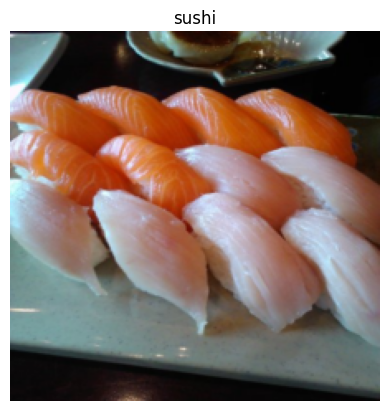

In [23]:
# View a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

In [24]:
# pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch diamension --> (batch size, Color_channels, height, width)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


Now we have passed a single image to our 'conv2d' layer,it's shape is
```python
torch.size([1,768,14]) # [batch_size, embedding dim, freature_map_height,feature_map_width]
```

In [25]:
image_out_of_conv.requires_grad

True

showing random convolutional feature maps from indexes: [233, 309, 57, 293, 300]


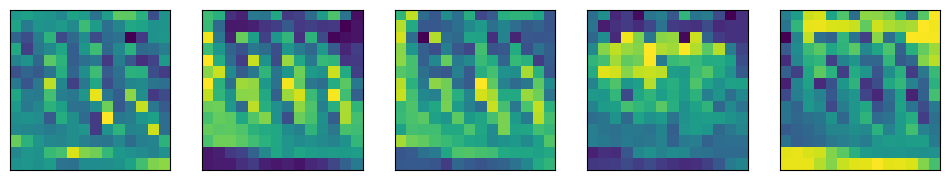

In [26]:
# plot random convolutional feature maps (embeddings)
import random
random_indexes = random.sample(range(0,758),k=5)
print(f'showing random convolutional feature maps from indexes: {random_indexes}')

# Create plot
fig,axs = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

# Plot random image features map
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx,:, :] # index on the output layer on the conv2d layer
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy()) # remove batch dimension and remove from grad tracking/switch to numpy for matplotlib
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [27]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:,0,:,:]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 8.7814e-02, -1.0575e-01,  2.1985e-02, -9.4052e-03,  2.7133e-02,
           -2.4763e-02,  1.0629e-01,  1.8986e-02, -2.1523e-02,  8.7905e-03,
            1.9399e-02,  9.0184e-03,  9.5343e-02, -2.3683e-02],
          [-2.0377e-02,  9.9421e-02, -2.5142e-02, -1.4668e-02, -2.2220e-02,
           -1.3910e-01,  5.1019e-02,  3.1055e-01,  3.4505e-02, -7.4650e-02,
           -5.3745e-02, -1.1778e-01, -3.7992e-02, -1.8793e-02],
          [ 3.6053e-02,  2.5971e-01,  3.7152e-01,  2.7122e-01,  1.8277e-01,
            3.0490e-01,  5.0785e-02,  2.4784e-01,  3.2491e-01,  1.1740e-01,
            2.1438e-01, -1.9332e-02, -2.3320e-02, -1.6546e-02],
          [ 2.6419e-03,  7.0887e-02,  1.8917e-01,  1.0806e-01,  1.1761e-01,
            1.9915e-01,  1.3351e-01,  6.9746e-02,  2.4548e-01,  1.6923e-01,
           -4.7799e-03,  2.4178e-01,  1.8173e-01,  2.9467e-02],
          [ 7.2460e-02,  7.1913e-02,  1.8924e-01,  2.1845e-01,  6.2107e-02,
            2.3486e-01,  2.9840e-01,  1.7134e-02,  6.4621e-0

### Flattening the patch embedding with torch.nn.Flatten()
We have a series of convolutional feature maps (patch embeddings) that we want to flatten into a sequence of patch embeddings to satisfiy the input critera of the vit Transformer Encoder.(hybrid arictecture of vit paper page 4/22)

In [28]:
print(f'{image_out_of_conv.shape} --> (batch_size , embedding_dim, feature_map_height, feature_map_weidth)')

torch.Size([1, 768, 14, 14]) --> (batch_size , embedding_dim, feature_map_height, feature_map_weidth)


We want (batch_size, number_of_patches, embeddeding_dim)

In [29]:
from torch import nn
flatten_layer = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

original image shape: torch.Size([3, 224, 224])
image feature map (patches) shape: torch.Size([1, 768, 14, 14])
flattened image feature map shape torch.Size([1, 768, 196])


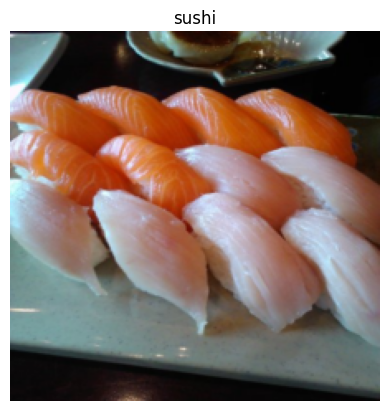

In [30]:
# put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'original image shape: {image.shape}')

# Turn image into feature map
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch diamension
print(f'image feature map (patches) shape: {image_out_of_conv.shape}')


# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"flattened image feature map shape {image_out_of_conv_flattened.shape}")


In [31]:
# Rearrage output flatened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0,2,1)
print(f"{image_out_of_conv_flattened_permuted.shape} --> batch_size, number of patches, embedding diamension")

torch.Size([1, 196, 768]) --> batch_size, number of patches, embedding diamension


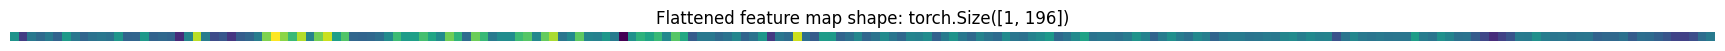

In [32]:
# get a single flattened feature map
single_flattend_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]
single_flattend_feature_map

#plot the feature map visulally
plt.figure(figsize=(22,22))
plt.imshow(single_flattend_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattend_feature_map.shape}")
plt.axis(False);

### Turning the VIT patch enbedding layer into a Pytorch module
We want this module to do a few things:


1.   Create a class called `PatchEmbedding`
2.   Initialize with appropriate hyperparameters, such as channels, embedding
  dimension, patch_size


3. Create a layer to turn an image into embedding patches using `nn.Conv2d`
4. Create a layer to flatten the feature maps of the output of the layer in 3.
5. Define a `forward()` defines the forward computation.(eg. pass through layer 3 and 4).
6. make sure the output layer shape of the layer reflects the required output shape of the patch embedding.









In [33]:
# 1. Create a class called patchEmbedding
class PatchEmbedding(nn.Module):
  # 2. initialize the layer with appropriate hyperparameters
  def __init__(self,
               in_channels:int=3,
               patch_size:int=16,
               embedding_dim:int=768
               ): # from the table 1 of the Vit paper for the vit-base model
    super().__init__()
    self.patch_size = patch_size

    # 3. create a layer to turn an image into embedded patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)
    # 3. Create a layer to flatten feature map outputs of conv2d
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3
                              )
  # 5. define a forward method to define the forward computation steps
  def forward(self,x):
    # Create an assertion to check that inputs are the correct shape
    image_resolution = x.shape[-1]
    assert  image_resolution % patch_size ==0, f'input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'\

    # perform the forward pass
    x_patched = self.patcher(x)
    x_flattened = self.flatten(x_patched)

    # 6. make sure that we return sequence embedding dimensions are in the right order ( batch_ size, number_of_patches, embedding_dim)
    return x_flattened.permute(0,2,1)

In [34]:
set_seeds()

#Create an instence of the patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# pass a single image through patch embedding layer
print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension
print(f'out patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
out patch embedding sequence shape: torch.Size([1, 196, 768])


In [35]:
rand_image_tensor = torch.randn(1,3,224,224)
rand_image_tensor_bad = torch.randn(1,3,250,250
                                  )
##patchify(rand_image_tensor_bad)

### Creating the class token embedding

We want: prepend a learnable class token to the start of the patch embedding.


In [36]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [37]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension


(1, 768)

In [38]:
# create class token embedding as a learnable parameter that shares the same size as the embedding dimension(D)
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension),
                           requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [39]:
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [40]:
# add the class token embedding to the front of the patch_embedding
patch_embedding_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                 dim = 1)# number_of_patch_dimensions
print(patch_embedding_with_class_embedding)
print(f"sequence of patch embedding with class token prepened shape: {patch_embedding_with_class_embedding.shape} -->(batch_size, class_token+number_of_patches, embedding_dim)")

tensor([[[-9.9595e-01,  1.4136e+00,  3.7235e-01,  ..., -7.8786e-01,
           3.6363e-01, -9.1862e-01],
         [-5.1891e-01,  1.5853e-01, -1.8475e-01,  ...,  3.9087e-01,
          -1.3754e-01,  1.2827e-01],
         [-5.2471e-01,  4.9548e-02, -5.8163e-02,  ...,  3.4501e-01,
          -2.2168e-01,  1.5795e-01],
         ...,
         [-1.7937e-01,  7.8274e-02,  7.7135e-02,  ...,  1.5774e-01,
          -2.3824e-01, -1.3393e-03],
         [-3.1257e-01,  8.0161e-02,  1.1158e-01,  ...,  1.7262e-01,
          -2.2843e-01, -1.3775e-02],
         [-3.7528e-01,  8.0650e-02,  6.2687e-02,  ...,  2.1085e-01,
          -2.5307e-01,  3.1250e-02]]], grad_fn=<CatBackward0>)
sequence of patch embedding with class token prepened shape: torch.Size([1, 197, 768]) -->(batch_size, class_token+number_of_patches, embedding_dim)


# creating the positional embedding

We want to : Create a series of 1D learnable positional embeddings and to add them to the sequence of patch embeddings.

In [41]:
# calulate N (number of patches)
number_of_patches = int((height*width)/patch_size**2)

# ge the embeding dimension
embeding_diamension = patch_embedding_with_class_embedding.shape[-1]

# create a learnable 1D postion embedding
position_embedding = nn.Parameter(torch.ones(1,
                                            number_of_patches+1,
                                            embedding_dimension),
                                 requires_grad=True)
position_embedding, position_embedding.shape

(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [42]:
# view the  sequence of patch embedding with the prepended class embedding
patch_embedding_with_class_embedding, patch_embedding_with_class_embedding.shape

(tensor([[[-9.9595e-01,  1.4136e+00,  3.7235e-01,  ..., -7.8786e-01,
            3.6363e-01, -9.1862e-01],
          [-5.1891e-01,  1.5853e-01, -1.8475e-01,  ...,  3.9087e-01,
           -1.3754e-01,  1.2827e-01],
          [-5.2471e-01,  4.9548e-02, -5.8163e-02,  ...,  3.4501e-01,
           -2.2168e-01,  1.5795e-01],
          ...,
          [-1.7937e-01,  7.8274e-02,  7.7135e-02,  ...,  1.5774e-01,
           -2.3824e-01, -1.3393e-03],
          [-3.1257e-01,  8.0161e-02,  1.1158e-01,  ...,  1.7262e-01,
           -2.2843e-01, -1.3775e-02],
          [-3.7528e-01,  8.0650e-02,  6.2687e-02,  ...,  2.1085e-01,
           -2.5307e-01,  3.1250e-02]]], grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [43]:
# Add the position embedding to the patch and class oken embedding
patch_and_position_embedding = patch_embedding_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f'patch and position embedding shape: {patch_and_position_embedding.shape}')

tensor([[[0.0041, 2.4136, 1.3723,  ..., 0.2121, 1.3636, 0.0814],
         [0.4811, 1.1585, 0.8152,  ..., 1.3909, 0.8625, 1.1283],
         [0.4753, 1.0495, 0.9418,  ..., 1.3450, 0.7783, 1.1580],
         ...,
         [0.8206, 1.0783, 1.0771,  ..., 1.1577, 0.7618, 0.9987],
         [0.6874, 1.0802, 1.1116,  ..., 1.1726, 0.7716, 0.9862],
         [0.6247, 1.0806, 1.0627,  ..., 1.2108, 0.7469, 1.0312]]],
       grad_fn=<AddBackward0>)
patch and position embedding shape: torch.Size([1, 197, 768])


### Putting it all together: from image to embedding
we have written code to turn an image into a flattened sequence of patch embedding. Now let's see them in one cell

In [44]:
# set seeds
set_seeds()

# set the patch size
patch_size = 16

# print the shapes of the originak image tensor and get the image dimensions
print(f'image tensor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

# get the image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

# create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                      embedding_dim=768
                                       )
# pass input image through PatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f'patch embedding shape: {patch_embedding.shape}')

# Create a class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it is learnable
print(f'class token embedding shape {class_token.shape}')

# prepend the class token embedding  to the patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding),dim=1)
print(f'patch embedding with class token shape: {patch_embedding_class_token.shape}')

# create position embedding
number_of_patches = int((height*width)/patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'patch and position embedding shape: {patch_and_position_embedding.shape}')

image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
patch embedding shape: torch.Size([1, 196, 768])
class token embedding shape torch.Size([1, 1, 768])
patch embedding with class token shape: torch.Size([1, 197, 768])
patch and position embedding shape: torch.Size([1, 197, 768])


 ## Multihead self attension(MSA Block)


*   Multihead Self Atention: Which par of a sequence should pay he most attension to itself?


*   In our case , we have a series of embedded image paches, which path significantly relates to another patch

*  We want our neural network (Vit) to learn this relationship/repercentation.

*   To replicate MSA in pytorch we can use : https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

*  LayerNorm = Layer normalization is a technique to normalize the distributions of intermediate layers. It enables smooth gradiens, faster training, and better generalization accuracy.

*  Normalization = make everything have the same mean and same standard deviation.


*   in pytorch = https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html , normalizes values over $D$ diamension , in our case the $D$ diamension is the embedding diamension.

*   












In [45]:
class MultiHeadSelfAttentionBlock(nn.Module):
  """Create  a multi-head self-attention block (MSA).
  """
  def __init__(self,
               embedding_dim:int=768, # Hidden size D from table1 from the vit paper
               num_heads:int=12, # heads from the table 1
               attn_dropout:float=0.0):
    super().__init__()

    # Create the norm layer (LN)
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create the multi-head attension layer
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)# is the bach first? --> (batch, number_of_patches, embedding_dim )


  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                         key=x,
                                         value=x,
                                         need_weights=False)
    return attn_output


In [46]:
# create an instence MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

# pass the patch and position image embedding sequence through MSA block
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f'input shape of MSA block : {patch_and_position_embedding.shape}')
print(f'Output shape of MSA block : {patched_image_through_msa_block.shape}')

input shape of MSA block : torch.Size([1, 197, 768])
Output shape of MSA block : torch.Size([1, 197, 768])


In [47]:
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.4811, 1.1585, 0.8152,  ..., 1.3909, 0.8625, 1.1283],
         [0.4753, 1.0495, 0.9418,  ..., 1.3450, 0.7783, 1.1580],
         ...,
         [0.8206, 1.0783, 1.0771,  ..., 1.1577, 0.7618, 0.9987],
         [0.6874, 1.0802, 1.1116,  ..., 1.1726, 0.7716, 0.9862],
         [0.6247, 1.0806, 1.0627,  ..., 1.2108, 0.7469, 1.0312]]],
       grad_fn=<AddBackward0>)

In [48]:
patched_image_through_msa_block

tensor([[[-0.2279, -0.1592,  0.0687,  ..., -0.4274,  0.8772, -0.4798],
         [-0.1983, -0.1273,  0.0790,  ..., -0.4312,  0.9051, -0.5102],
         [-0.1902, -0.1260,  0.0756,  ..., -0.4369,  0.9033, -0.5176],
         ...,
         [-0.1897, -0.1664,  0.0624,  ..., -0.4312,  0.8850, -0.5056],
         [-0.1907, -0.1586,  0.0575,  ..., -0.4342,  0.8912, -0.5071],
         [-0.1938, -0.1536,  0.0602,  ..., -0.4369,  0.8960, -0.5083]]],
       grad_fn=<TransposeBackward0>)

## Equation 3 : Multilayer Perceptron (MLP Block)

*  **MLP** = The MLP contains two layers with a GELU non-linearity (section 3.1)
*  MLP = a quite broad term for a block with a series of layer(s),layers can be ,ultiple or even only one hidden layer
* Layers can mean : fully connected , dense, linear, feed-forward all are often similar names for the same thing. In Pytorch, they're often called `torch.nn.Linear()` and in Tensorflow it is called `tf.keras.Dense()`
* GELU in Pytorch :https://pytorch.org/docs/stable/generated/torch.nn.GELU.html

* **Dropout** =  Droupout, when used, is applied after every dense layer except for the qkv-projections and directly after adding positional - patch embeddings. Hybrid models are trained with the exact setup as their VIT counerparts.

* value of droupout available in table 3

In pseudocode:
```python
# MLP
x = Linear --> non-linear --> droupout --> linear --> dropout
```

In [49]:
class MLPBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768,
               mlp_size:int=3072,
               dropout:int=0.1

               ):
     super().__init__()
     # Create the norm layer (LN)
     self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

     # Create the MLP
     self.mlp = nn.Sequential(
         nn.Linear(in_features=embedding_dim,
                   out_features=mlp_size),
         nn.GELU(),
         nn.Dropout(p=dropout),
         nn.Linear(in_features=mlp_size,
                   out_features=embedding_dim),
         nn.Dropout(p=dropout)
     )
  def forward(self,x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    # Return self.mlp(self.layer_norm(x))


In [50]:
# Create an instence of MLP Block
mlp_block = MLPBlock(embedding_dim=768,
                     mlp_size=3072,
                     dropout=0.1)
# Pass output the MSABlock through the MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f'input shape of mlp block: {patched_image_through_msa_block.shape}')
print(f'output shape of MSA block: {patched_image_through_mlp_block.shape}')


input shape of mlp block: torch.Size([1, 197, 768])
output shape of MSA block: torch.Size([1, 197, 768])


In [51]:
patched_image_through_mlp_block

tensor([[[-0.0224, -0.0050,  0.1232,  ...,  0.0000, -0.1473,  0.1931],
         [-0.0628, -0.1270,  0.2460,  ..., -0.0953, -0.1218,  0.2030],
         [ 0.0046, -0.0595,  0.2576,  ..., -0.0000, -0.1765,  0.1819],
         ...,
         [-0.1623, -0.0124,  0.2490,  ...,  0.1143, -0.1895,  0.2816],
         [-0.0963,  0.0406,  0.0000,  ...,  0.0625, -0.1614,  0.0755],
         [-0.0390, -0.0269,  0.2200,  ..., -0.1079, -0.1499,  0.1794]]],
       grad_fn=<MulBackward0>)

In [52]:
patched_image_through_msa_block

tensor([[[-0.2279, -0.1592,  0.0687,  ..., -0.4274,  0.8772, -0.4798],
         [-0.1983, -0.1273,  0.0790,  ..., -0.4312,  0.9051, -0.5102],
         [-0.1902, -0.1260,  0.0756,  ..., -0.4369,  0.9033, -0.5176],
         ...,
         [-0.1897, -0.1664,  0.0624,  ..., -0.4312,  0.8850, -0.5056],
         [-0.1907, -0.1586,  0.0575,  ..., -0.4342,  0.8912, -0.5071],
         [-0.1938, -0.1536,  0.0602,  ..., -0.4369,  0.8960, -0.5083]]],
       grad_fn=<TransposeBackward0>)

## Creating  a custom Transformer Encorder

* The Transformer Encoder is a combination of alternating blocks of MSA(eqn2) and MLP(Eqn3).
And there are residual connection between each block.
  * Encoder = Turns a sequence into learnable repercentaion
  * Decoder = Go from learn repercentaion back fo some sort of sequence.
  * Residual connection = Add a layer(s) input to its sebsiquent output, this enables the creation of deeper networks (prevents weights from getting too small)

  In pseudocode:

```python
# Transformer Encoder
x_input -> MSA_Block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_Block_output + x_input] -> ....
```



In [53]:
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim:int=768, #Hidden size D from table1
               num_heads:int=12,# From table 1
               mlp_size:int=3072, # From the table 1
               mlp_dropout:int=0.1, # from table 3
               attn_dropout:int=0):
    super().__init__()

    #Create MSA block (eqn 2)
    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)

    # Create the MLP Block (eqn 3)
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)

  # Create a froward mehod
  def forward(self,x):
    x = self.msa_block(x) + x # residual connection for equaion 2
    x = self.mlp_block(x) + x # residual connection for equaion 3
    return x

In [54]:
# Create an instance of TransformerEncoderBlock()
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1,197,768), # batch size, number of patches,embedding_dimension
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Create a transformer encoder using pytorch transformer encoder layer:
https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html: This is more efficient when done in a certain way.


In [55]:
# Creating the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12,# heads from the table 1
                                                             dim_feedforward=3072, #MLP size from table
                                                             dropout=0.1,
                                                             activation='gelu',
                                                             batch_first=True,
                                                             norm_first=True

                                                            )
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [56]:


# Get a summary using torchinfo.summary
summary(model=torch_transformer_encoder_layer,
        input_size=(1,197,768), # batch size, number of patches,embedding_dimension
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

## Creating the VIT Paper


In [57]:
import torch
import torch.nn as nn

class Vit(nn.Module):
    def __init__(self,
                 img_size: int = 224,  # From Table 3 of the ViT paper
                 in_channels: int = 3,
                 patch_size: int = 16,
                 num_transformer_layers: int = 12,  # Table 1 for layers
                 embedding_dim: int = 768,  # Hidden size D from Table 1
                 mlp_size: int = 3072,
                 num_heads: int = 12,
                 attn_dropout: float = 0.0,
                 mlp_dropout: float = 0.1,
                 embedding_dropout: float = 0.1,
                 num_classes: int = 1000):
        super().__init__()

        # Assert image size is compatible with patch size
        assert img_size % patch_size == 0, \
            f"Image size must be divisible by patch size, image: {img_size}, patch size: {patch_size}"

        # Calculate the number of patches (height * width / patch_size^2)
        self.num_patches = (img_size * img_size) // (patch_size ** 2)

        # Create learnable class embeddings
        self.class_embedding = nn.Parameter(torch.randn(1, 1, embedding_dim), requires_grad=True)

        # Create learnable positional embeddings
        self.position_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embedding_dim))

        # Create embedding dropout layer
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )

        # Create Transformer Encoder blocks
        self.transformer_encoder = nn.Sequential(*[
            TransformerEncoderBlock(
                embedding_dim=embedding_dim,
                num_heads=num_heads,
                mlp_size=mlp_size,
                attn_dropout=attn_dropout,
                mlp_dropout=mlp_dropout
            ) for _ in range(num_transformer_layers)
        ])

        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass for the Vision Transformer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, img_size, img_size).

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes).
        """
        # Get the batch size
        batch_size = x.shape[0]

        # Create a class token embedding and expand it to match the batch size
        class_token = self.class_embedding.expand(batch_size, -1, -1)  # '-1' means infer the dimension

        # Create the patch embeddings
        x = self.patch_embedding(x)

        # Concatenate class token embedding and patch embeddings
        x = torch.cat((class_token, x), dim=1)

        # Add positional embeddings
        x = self.position_embedding + x

        # Apply dropout to the embeddings
        x = self.embedding_dropout(x)

        # Pass embeddings through the Transformer encoder
        x = self.transformer_encoder(x)

        # Classify using the 0th index (class token)
        x = self.classifier(x[:, 0])

        return x


In [58]:
set_seeds()

# Create a random image tensor with same shape as a  single image
random_image_tensor = torch.randn(1,3,224,224)

# create an instance of the VIT  with the no: of classes we are working with
vit = Vit(num_classes=len(class_names))

# Pass the random image tensor to our VIT instance
vit(random_image_tensor)

tensor([[-0.2377,  0.7360,  1.2137]], grad_fn=<AddmmBackward0>)

In [59]:
from torchinfo import summary

summary(model=Vit(num_classes=len(class_names)),
        input_size=(1,3,224,224), # batch size, color channels, height, width
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Output Shape         Param #
Vit (Vit)                                                    [1, 3]               152,064
├─PatchEmbedding (patch_embedding)                           [1, 196, 768]        --
│    └─Conv2d (patcher)                                      [1, 768, 14, 14]     590,592
│    └─Flatten (flatten)                                     [1, 768, 196]        --
├─Dropout (embedding_dropout)                                [1, 197, 768]        --
├─Sequential (transformer_encoder)                           [1, 197, 768]        --
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        --
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        2,363,904
│    │    └─MLPBlock (mlp_block)                             [1, 197, 768]        4,723,968
│    └─TransformerEncoderBlock (1)                           [1, 197, 768]        --
│    │    └─MultiHeadSelfAttentionBl

### Setting up training code for our custom VIT

# Create an optimizer

The paper states that it uses the Adam opimizer (section 4, training and fine tunning) with $B1$ value of 0.9, $B2$ of 0.999(default) and a weightdecay of 0.1.

Weight decay=weight decay is a regularization technique by adding a small penalty, usually the L2 norm of the weight (all the weights of the model), to the loss function.

Regularization technique = prevents overfitting.

### Creating a loss function

The Vit paper doesn't actually mension what loss function they used.
so since it's a multi-class classification we'll use the `torch.nn.CrossEntropyLoss()`

### Training our Model


In [60]:
import engine
optimizer = torch.optim.Adam(vit.parameters(),
                             lr=1e-3,
                             betas=(0.9,0.999),
                             weight_decay=0.1)
loss_fn = torch.nn.CrossEntropyLoss()

results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       epochs=10,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       device=device
                       )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.6697 | train_acc: 0.3086 | test_loss: 1.2545 | test_acc: 0.5417
Epoch: 2 | train_loss: 1.5149 | train_acc: 0.3203 | test_loss: 1.0593 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.3925 | train_acc: 0.4219 | test_loss: 1.3158 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2488 | train_acc: 0.4219 | test_loss: 2.3024 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.5335 | train_acc: 0.2852 | test_loss: 1.9660 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.5853 | train_acc: 0.3164 | test_loss: 1.2593 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.3238 | train_acc: 0.4375 | test_loss: 1.1766 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2108 | train_acc: 0.2617 | test_loss: 1.9692 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.5777 | train_acc: 0.2891 | test_loss: 1.4056 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1396 | train_acc: 0.4219 | test_loss: 1.1256 | test_acc: 0.5417


### Since our model is not performing as expected we have to do some fine-tunning.
The main things we are missing in our training implementaion are:

### Under fitting
* Data - our training setup uses less data compared to the paper (225 vs millions)

### OverFitting
* Learning Rate warmup - Start with a low learning rate and increase to the base LR
* Learning rate decay - as our model gets closser to convergence, start to lower the lr
* Gradient clipping - prevent gradients from getting too big




### Plotting loss curves for our model

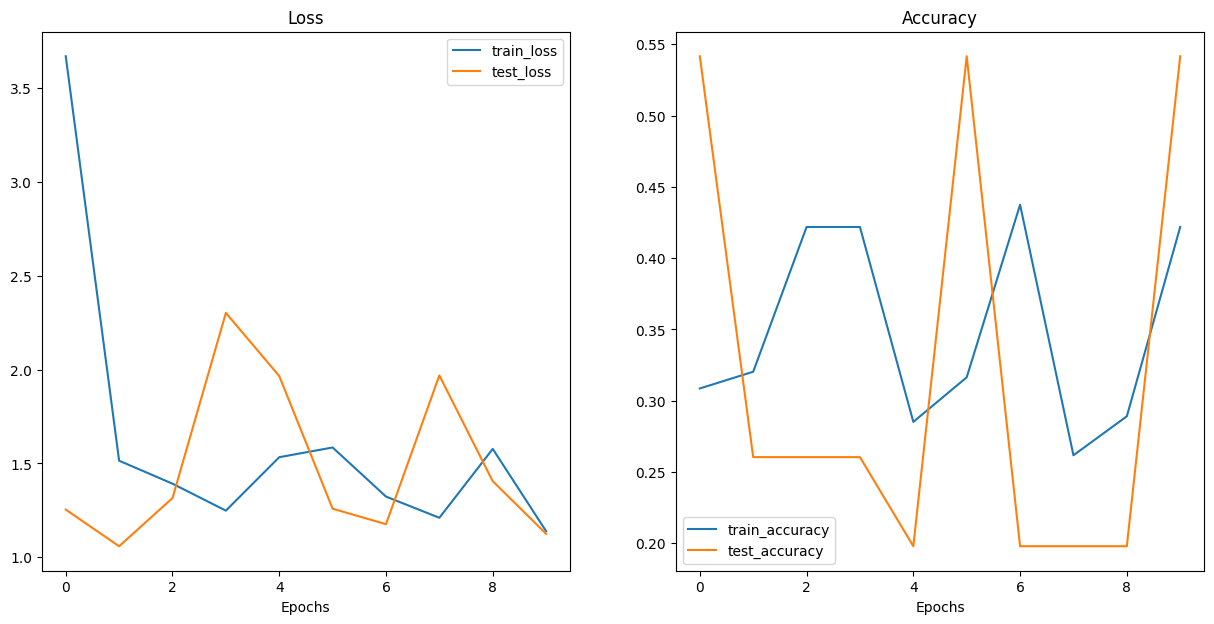

In [61]:
from helper_functions import plot_loss_curves
plot_loss_curves(results)

### Using a pretrained Vit from `torchvision.models`

**Advantages of using pretrained models**
* Get better results when we have a small amount of data
* Can use when we have limited training resourse


# resource : https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16

In [62]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
# Get pretrained weights for Vit-base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# setup a Vit model instance of pretrained weights
pretrained_vit = vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameter
for parameter in pretrained_vit.parameters():
  parameter.requires_grad = False

# Update the classifiyer head
set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 147MB/s]


In [63]:
from torchinfo import summary

summary(model=pretrained_vit,
        input_size=(1,3,224,224), # batch size, color channels, height, width
        col_names=['input_size','output_size','num_params','trainable'],
        col_width=20,
        row_settings=['var_names'])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Prepareing data for the pretrained vit model
When using a pretrained model, you want to make sure your data is formated in the same way the model is trained on.



In [64]:
# Get automatic transforms from pretrained ViT weights
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [65]:
# setup dataloader
trained_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                       test_dir=test_dir,
                                                                                                       transform=vit_transforms,
                                                                                                       batch_size=32)

### Train feature extractor ViT model


In [66]:
import engine

# create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

# train the classifiyer head of pretrained Vit
set_seeds()
pretrained_vit_result = engine.train(model=pretrained_vit,
                                     train_dataloader=trained_dataloader_pretrained,
                                     test_dataloader=test_dataloader_pretrained,
                                     epochs=10,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7663 | train_acc: 0.7188 | test_loss: 0.5435 | test_acc: 0.8769
Epoch: 2 | train_loss: 0.3436 | train_acc: 0.9453 | test_loss: 0.3257 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.2068 | train_acc: 0.9492 | test_loss: 0.2698 | test_acc: 0.9186
Epoch: 4 | train_loss: 0.1557 | train_acc: 0.9609 | test_loss: 0.2414 | test_acc: 0.9186
Epoch: 5 | train_loss: 0.1244 | train_acc: 0.9727 | test_loss: 0.2271 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.1210 | train_acc: 0.9766 | test_loss: 0.2122 | test_acc: 0.9280
Epoch: 7 | train_loss: 0.0933 | train_acc: 0.9766 | test_loss: 0.2342 | test_acc: 0.8883
Epoch: 8 | train_loss: 0.0793 | train_acc: 0.9844 | test_loss: 0.2268 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.1084 | train_acc: 0.9883 | test_loss: 0.2064 | test_acc: 0.9384
Epoch: 10 | train_loss: 0.0646 | train_acc: 0.9922 | test_loss: 0.1795 | test_acc: 0.9176


In [67]:
### Plot the loss curves of our pretrained Vit feature extractor model


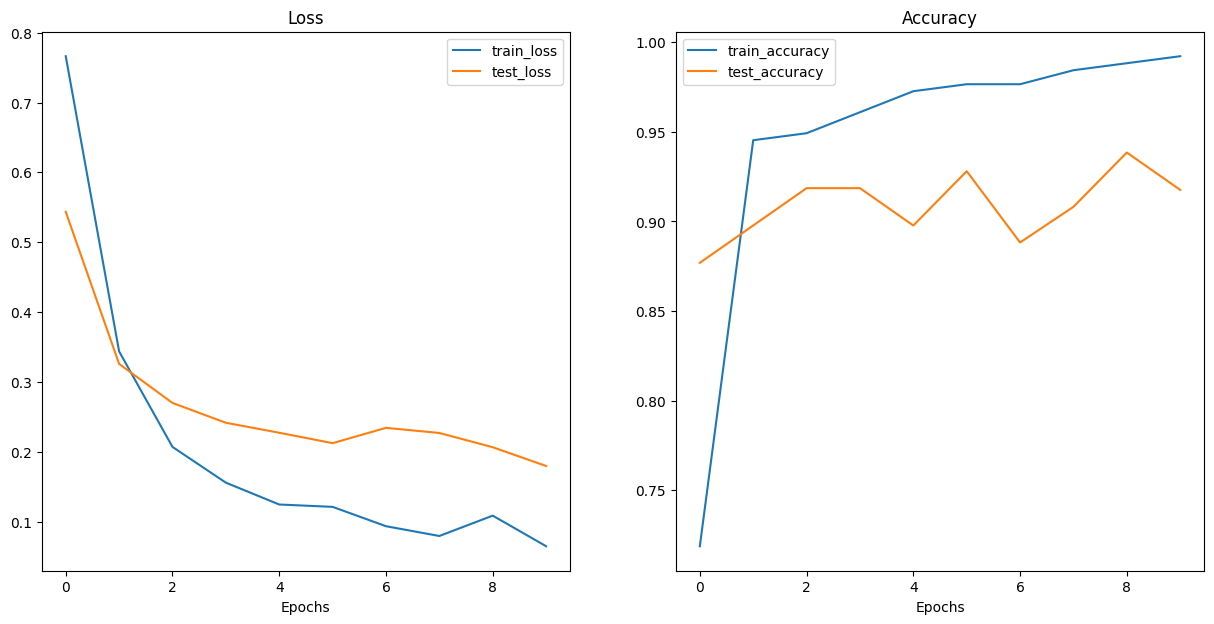

In [68]:
from helper_functions import plot_loss_curves
plot_loss_curves(pretrained_vit_result)

### Save our pretrained model

In [69]:
import utils

utils.save_model(model=pretrained_vit,
                 target_dir="models",
                 model_name="pretrained_vit_feaure_extractor_pizza_stake_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_feaure_extractor_pizza_stake_sushi.pth


In [70]:
from pathlib import Path

# get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path('models/pretrained_vit_feaure_extractor_pizza_stake_sushi.pth').stat().st_size//(1024*1024)
print(f"pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

pretrained ViT feature extractor model size: 327 MB
